### University of Washington: Machine Learning and Statistics 

# Lecture 11: Approximate Bayesian Computation

Andrew Connolly and Mario Juric

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 5.10
- [astroML website](https://www.astroml.org/index.html)
- [astroML ABC example](https://www.astroml.org/astroML-notebooks/chapter5/astroml_chapter5_Approximate_Bayesian_Computation.html)
- [pymc3 ABC example](https://docs.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html)
- [Approximate Bayesian computation for forward modeling in cosmology](https://ui.adsabs.harvard.edu/link_gateway/2015JCAP...08..043A/PUB_HTML) by Akeret et al.
- [A tutorial on approximate Bayesian computation](https://www.sciencedirect.com/science/article/pii/S0022249612000272) by Turner and Van Zandt

This notebook is developed based on material from A. Connolly,Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and associated material are available from [github](https://github.com/uw-astro/astr-598a-spr24).

The jupyterhub with the software installed is available at [jupyterhub](https://jupyter.rttl.uw.edu/2024-spring-astr-598-a).

## When likelihoods are hard

Astronomical models are often stochastic, like simulations of the temperature map of the CMB, of the large-scale structure of galaxies, and of the mass and luminosity distribution for stars and galaxies. In these cases, it can be hard or impossible to write down a data likelihood function, or the data likelihood function may be expensive to compute. Often, astronomers vary the input parameters of the simulation until some summary statistic, like the CMB angular power spectrum or stellar luminosity function, matches the observed data. Approximate Bayesian Computation are a category of methods to make this inference less ad hoc and more efficient.

To use Approximate Bayesian Computation, we need to be able to simulate our observed data, that is, we need to be able to draw samples from:
$$ P(x \mid \theta) $$
where $x$ are our (simulated) data and $\theta$ are the model parameters. Instead of a likelihood, we define some distance metric $D(x, y)$ between the simulated data $x$ and the observed data $y$.

## Rejection sampling
Let's imagine a procedure where we accept simulation parameters if they generate data that are close to the observed data, where "close" is defined by some distance threshold $\epsilon$:
$$ D(x,y) < \epsilon $$
If we sample simulation parameters from the prior $P(\theta)$, then the distribution of accepted parameters is an approximation to the posterior:
$$ P(\theta \mid x) \approx P(\theta \mid D(x, y) < \epsilon) $$
which is exactly correct for $\epsilon = 0$. The smaller $\epsilon$ is, the better the approximation, but the more samples will be rejected. To reduce the dimensionality of the data and thus raise the acceptance fraction, summary statistics $S$ are often used. If $S$ is a sufficient statistic, no information is lost, but finding sufficient statistics is difficult without knowing the likelihood.
$$ P(\theta \mid x) \approx P(\theta \mid D(S(x), S(y)) < \epsilon) $$

## Population Monte Carlo
Instead of just drawing from the prior, we can do better by refining our proposal distribution for parameters to simulate. Let's start by using rejection sampling on the prior $p_0(\theta)$ to get a first set of parameters $\{\theta_i^{(0)}\}$ that fufill a distance criterion $\epsilon_0$. Then in the next round, we construct a new proposal distribution by adding together kernels centred on $\{\theta^{(0)}\}$:
$$ p_1(\theta) \propto \sum_i K_1(\theta_i^{(1)} \mid \theta_i^{(0)}) $$
We sample $\{\theta_i^{(1)}\} \sim p_1(\theta)$ and accept the proposals that pass a (possibly more stringent) distance criterion $\epsilon_1$. We weight these samples to correct for the fact we sampled from the proposal $p_1$ instead of the prior $p_0$:
$$ w_i^{(1)} \propto \frac{p_0(\theta_i^{(1)})}{p_1(\theta_i^{(1)})} $$

We iterate, using reweighted samples $\{\theta_i^{(j-1)}\}$ to construct a new proposal distribution $p_j$ (with possibly a different kernel $K_j$):
$$ p_{j}(\theta) \propto \sum_i w_i^{(j-1)} K_j(\theta_i^{(j)} \mid \theta_i^{(j-1)})$$
And samples that are accepted by the criterion $\epsilon_j$ are reweighted for the next round:
$$ w_i^{(j)} \propto \frac{p_0(\theta_i^{(j)})}{p_j(\theta_i^{(j)})} $$

## An toy problem

Let's imagine we're observing gamma rays from a star that has two states, quiescent and flaring. Each minute, the star has a chance $q$ to flip between the states. When the object is quiescent, it emits $b$ photons per minute on average, and when it is active, it emits some higher $b+f$ photons per minute. We observe photon counts per minute over an hour and want to constrain $(q,b,f)$. We *could* find a data likelihood using the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm), but that looks *hard*. Let's try ABC using pymc3. First, we need our simulator function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def sim_flares(q, b, f, return_states=False):
    # number of times observed
    nt = 60
    # store observed photon counts
    k = np.zeros(nt, dtype=np.int32)
    # store states
    s = np.zeros(nt, dtype=np.bool_)
    
    for i in range(nt):
        if i == 0:
            s[i] = np.random.randint(2) # randomize starting state
        else:
            if np.random.uniform() < q:
                s[i] = 1 - s[i-1] # flip state
            else:
                s[i] = s[i-1] # keep state
        
        # if s == 1, expected flux is b+f, else it is b
        k[i] = np.random.poisson(b+f) if s[i] == 1 else np.random.poisson(b)
        
    if return_states:
        return s, k
    else: # only return counts for ABC
        return k

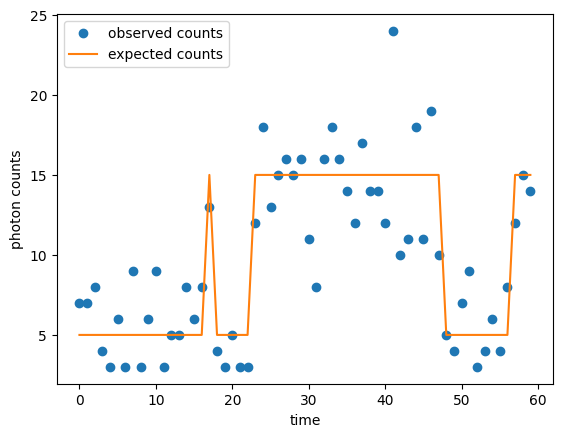

In [3]:
q_true = 0.1
b_true = 5
f_true = 10
np.random.seed(0) # make observed data set always the same
states, data = sim_flares(q_true, b_true, f_true, return_states=True)
np.random.seed() # re-randomize for later
plt.plot(data, ls='', marker='o', label='observed counts')
plt.plot(5+states*10, label='expected counts')
plt.legend()
plt.ylabel('photon counts')
plt.xlabel('time')
plt.show()

### Exercise
What summary statistics can you come up with for this data set that would allow us to constrain the flip probability $q$, the quiescent flux $b$, and the additional flare flux $f$?

## Implementation in pymc3
There's a nice [example](https://docs.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html) of how to do SMC ABC in `pymc3`, which we can mimic:

In [4]:
%%time
with pm.Model():
    # set up priors
    q = pm.Uniform("q", lower=0, upper=1)
    b = pm.Uniform("b", lower=0, upper=25)
    f = pm.Uniform("f", lower=0, upper=25)
    
    # set up simulator, summary statistic, distance, and data
    s = pm.Simulator("sim", sim_flares, params=(q, b, f), sum_stat="sort", epsilon=1, observed=data)

    # sample!
    trace1 = pm.sample_smc(kernel="ABC", parallel=True)

Initializing SMC sampler...
Multiprocess sampling (5 chains in 5 jobs)
/opt/conda/lib/python3.9/site-packages/pymc3/smc/sample_smc.py:168: UserWarning: Warning: SMC-ABC is an experimental step method and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
INFO (theano.gof.compilelock): Waiting for existing lock by process '53561' (I am process '53563')
INFO (theano.gof.compilelock): Waiting for existing lock by process '53561' (I am process '53562')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-6.6-linuxkit-x86_64-with-glibc2.35-x86_64-3.9.13-64/lock_dir
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-6.6-linuxkit-x86_64-with-glibc2.35-x86_64-3.9.13-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '53561' (I am process '53564')
INFO (theano.gof.compilelock): Waiting for existing lock by process '53561' (I am process

CPU times: user 768 ms, sys: 780 ms, total: 1.55 s
Wall time: 3min 41s


/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


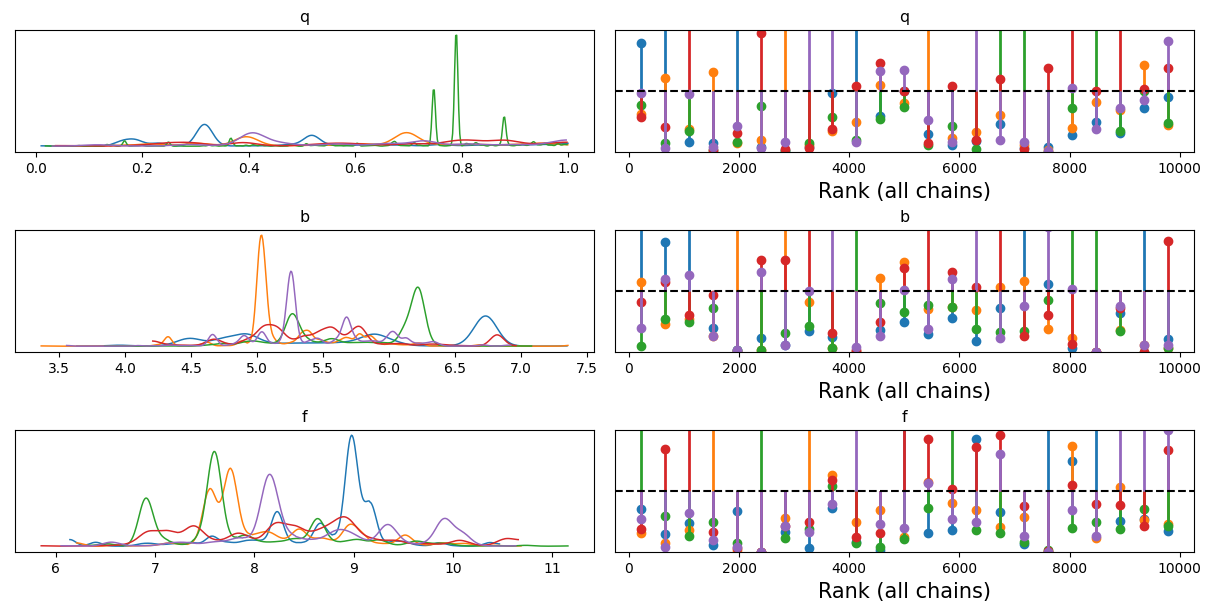

In [5]:
pm.plot_trace(trace1, kind="rank_vlines")
plt.show()

Well, that doesn't look great. I'd like to fix it, but I can't find online documentation for `pm.Simulator`, which seems crucial to the whole operation! Fortunately, `pm.Simulator` has a good docstring:

In [6]:
help(pm.Simulator)

Help on class Simulator in module pymc3.distributions.simulator:

class Simulator(pymc3.distributions.distribution.NoDistribution)
 |  Simulator(function, *args, params=None, distance='gaussian_kernel', sum_stat='identity', epsilon=1, **kwargs)
 |  
 |  Method resolution order:
 |      Simulator
 |      pymc3.distributions.distribution.NoDistribution
 |      pymc3.distributions.distribution.Distribution
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, function, *args, params=None, distance='gaussian_kernel', sum_stat='identity', epsilon=1, **kwargs)
 |      This class stores a function defined by the user in Python language.
 |      
 |      function: function
 |          Python function defined by the user.
 |      params: list
 |          Parameters passed to function.
 |      distance: str or callable
 |          Distance functions. Available options are "gaussian_kernel" (default), "wasserstein",
 |          "energy" or a user defined function that tak

So in this setup, `sum_stat = 'sort'` sorts our time series in ascending order of counts before calculating a distance. This turns our time series into something more like a CDF that reflects the fraction of time the star emits more than $k$ photons. This doesn't really give us a handle on how often the star flips states, though, as we've completely lost the time ordering. The default `distance='gaussian'` basically calculates a sum of squared errors against our sorted time series.

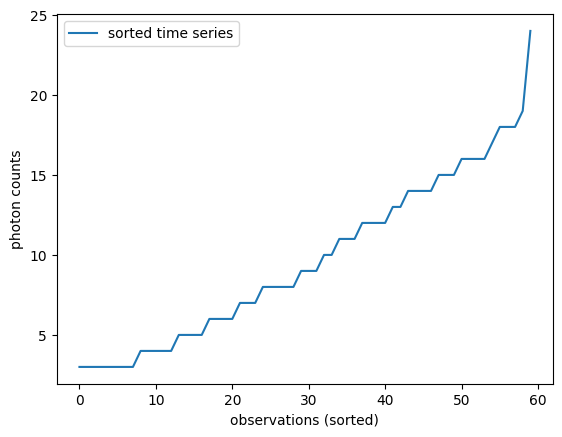

In [7]:
plt.plot(np.sort(data), label='sorted time series')
plt.ylabel('photon counts')
plt.xlabel('observations (sorted)')
plt.legend()
plt.show()

`sum_stat = 'identity'` would leave our time series unchanged, but it seems unlikely that even if we got the parameters $(q, b, f)$ right that we would generate a simulated light curve that changes state at the same times as our observed light curve. We need to come up with summary statistics that reflect the number of flips, which simulations at the right parameter values should be able to match. To attempt to capture flips, I consider the changes in photon count in adjacent observations, `data[1:] - data[0:-1]`, and take the standard deviation. Flips in state should cause large changes in photon counts, and if flips happen more often, that should increase the standard deviation. Thus, I expect `np.std(data[1:] - data[0:-1])` to constrain $q$.

To constrain $b$ and $f$, I take the mean and standard deviation of the light curve. The mean should constrain the mean of $b$ and $f$ and the standard deviation should constrain the difference.

In [8]:
def sum_stat(data):
    return np.array([np.mean(data), np.std(data), np.std(data[1:] - data[0:-1])])

Let's also adjust our distance metric, based on the standard deviation of our summary statistics on different simulations at our true values:

In [9]:
ntrials = 100
sum_stat_array = np.zeros((ntrials, 3))
for i in range(ntrials):
    sum_stat_array[i] = sum_stat(sim_flares(q_true, b_true, f_true))
epsilon_arr = np.std(sum_stat_array, axis=0)
print(epsilon_arr)

[1.9847701  0.63709638 0.63994373]


In [10]:
%%time
with pm.Model():
    # set up priors
    q = pm.Uniform("q", lower=0, upper=1)
    b = pm.Uniform("b", lower=0, upper=25)
    f = pm.Uniform("f", lower=0, upper=25)
    
    # set up simulator, summary statistic, distance, and data
    s = pm.Simulator("sim", sim_flares, params=(q, b, f), sum_stat=sum_stat, epsilon=epsilon_arr, observed=data)

    # sample!
    trace2 = pm.sample_smc(kernel="ABC", parallel=True)

Initializing SMC sampler...
Multiprocess sampling (5 chains in 5 jobs)
/opt/conda/lib/python3.9/site-packages/pymc3/smc/sample_smc.py:168: UserWarning: Warning: SMC-ABC is an experimental step method and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
INFO (theano.gof.compilelock): Waiting for existing lock by process '53970' (I am process '53969')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-6.6-linuxkit-x86_64-with-glibc2.35-x86_64-3.9.13-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '53970' (I am process '53971')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-6.6-linuxkit-x86_64-with-glibc2.35-x86_64-3.9.13-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '53968' (I am process '53971')
INFO (theano.gof.compilelock): Waiting for existing lock by process '53968' (I am process

CPU times: user 405 ms, sys: 270 ms, total: 675 ms
Wall time: 1min 40s


/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


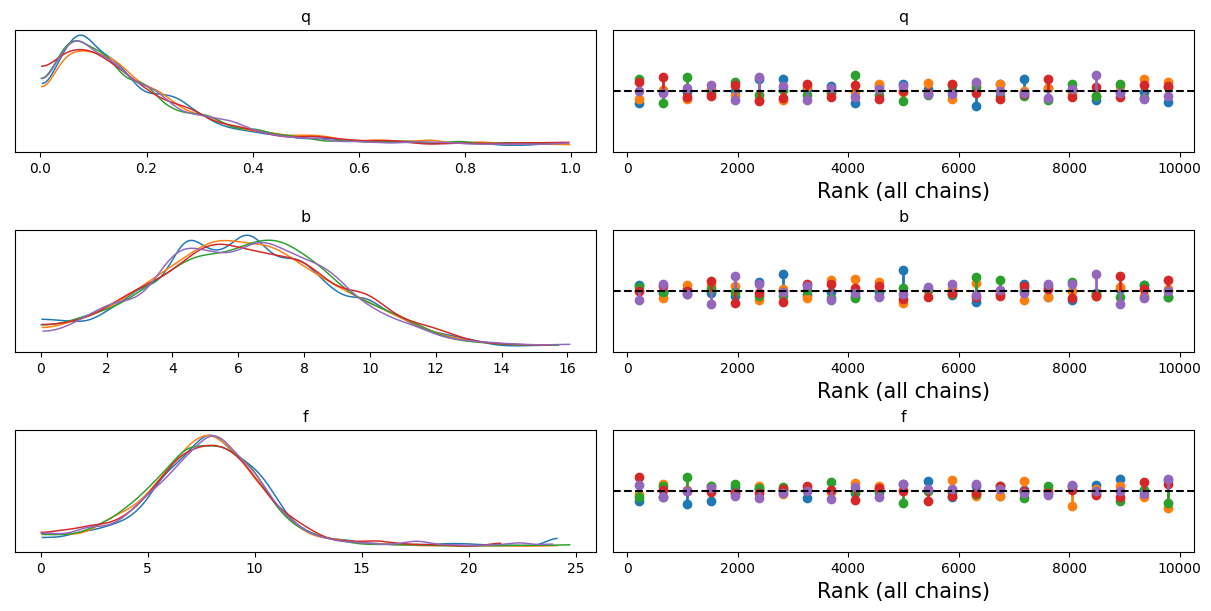

In [11]:
pm.plot_trace(trace2, kind="rank_vlines")
plt.show()

This chain looks much better, but more can probably be done to choose summary statistics and distances to improve this inference.

## Adding parameters makes the likelihood doable?

The stochasticity of when the star flips states makes it difficult to write down the likelihood $P(\{k_t\} \mid q, b, f)$, but if we add the star's state at all times, $\{s_t\}$, as parameters, we can turn our model into a hierarchical one where we can write down a likelihood:

$$ P(\{k_t\} \mid q, b, f, \{s_t\}) = \prod_t \left[ P(k_t \mid b, f, s_t) \right] P(\{s_t\} \mid q)$$
where
$$ k_t \mid b, f, s_t \sim \begin{cases} {\rm Poisson}(b) {\rm \,if\,} s_t = 0 \\
{\rm Poisson}(b+f) {\rm \,if\,} s_t = 1 \end{cases}$$
and where $n$ is the number of state flips in $\{s_t\}$ and $N$ is the number of observations:
$$ P(\{s_t\} \mid q) = q^n (1-q)^{N - n} $$

Now we have an analytic likelihood, but at the cost of 60 (!) extra parameters for the star's unknown state at each time. For our short time series, it's possible to sample from this likelihood, but for a longer time series, this change may make the sampling untenable. We'll use this exact likelihood to see how well our ABC is doing.

In [12]:
with pm.Model():
    # set up priors
    q = pm.Uniform("q", lower=0, upper=1)
    b = pm.Uniform("b", lower=0, upper=25)
    f = pm.Uniform("f", lower=0, upper=25)
    
    # parameters for hidden states
    s = pm.Bernoulli("s", p=0.5, shape=data.size)
    # count number of state flips
    nflip = tt.sum(tt.abs_(s[0:-1] - s[1:]))
    # binomial probability for number of state flips
    s_pot = pm.Potential("s_pot",  nflip * tt.log(q) + (data.size - nflip) * tt.log(1-q))
    
    # given the state, observed counts is either Poisson(b) or Poisson(b+s)
    k = pm.Poisson("k", mu=b+f*s, observed=data)
    
    # sample!
    trace3 = pm.sample(draws=1000, tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [f, b, q]
>BinaryGibbsMetropolis: [s]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.


/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (63), generating only 20 plots
  warnings.warn(


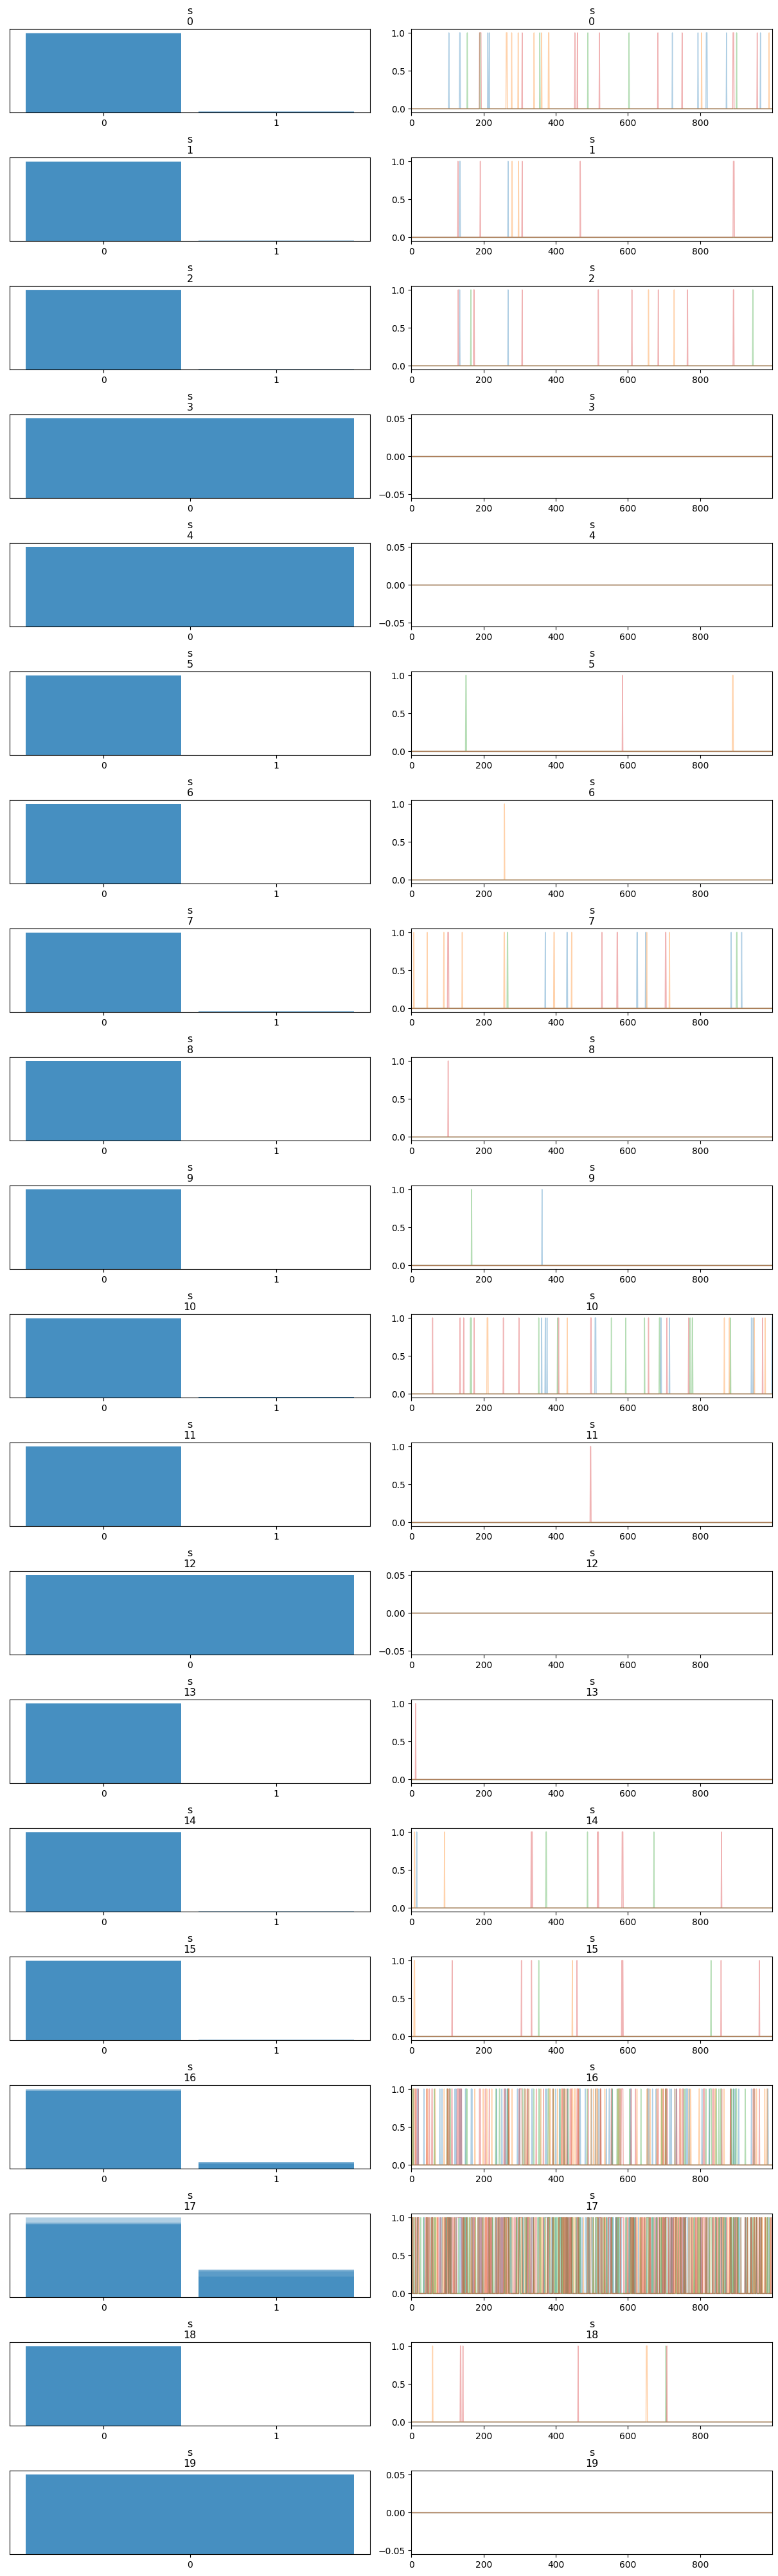

In [13]:
pm.plot_trace(trace3)
plt.show()

Hmm, that looks pretty good, let's compare to the ABC:

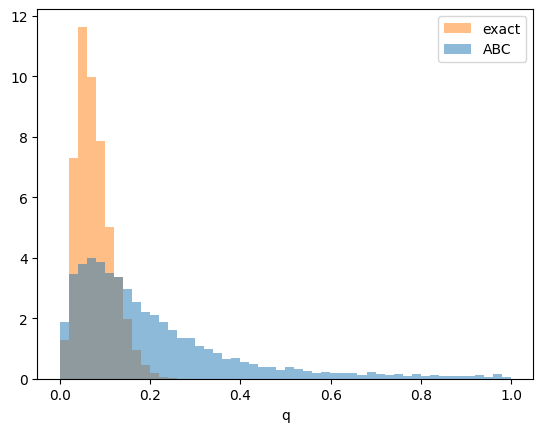

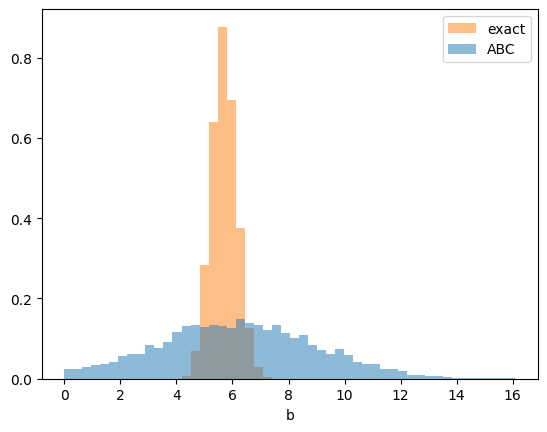

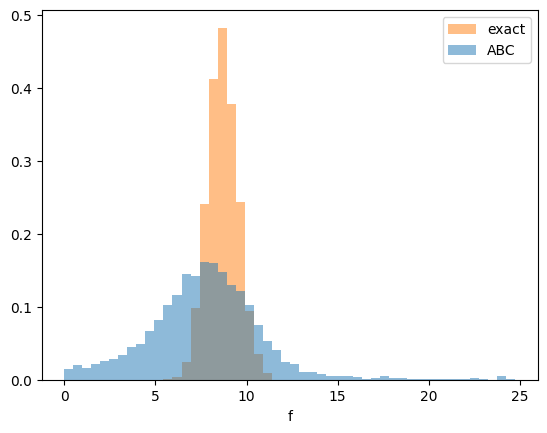

In [14]:
for par in ['q', 'b', 'f']:
    plt.hist([trace2[par], trace3[par]], label=['ABC', 'exact'], density=True, histtype='stepfilled', alpha=0.5, bins=50)
    plt.xlabel(par)
    plt.legend()
    plt.show()

The ABC inference is less constraining, but is still consistent with the exact inference. Try different summary statistics and distance metrics to see if you can improve the ABC inference!